In [1]:
import ares
import numpy as np
import matplotlib.pyplot as pl
import distpy

In [97]:
def getMasses(redshifts):
    data = ares.analysis.GalaxyPopulation()

    Ms = []
    for z in redshifts:
        data_info = data.compile_data(z, quantity='smf')

        # print(data_info)

        mass = []
        for i in data_info:
            print(i)
    #         mass.append(data_info[i]["M"][~data_info[i]["M"].mask])
            mass.extend(data_info[i]["M"].compressed())

        Ms.extend(mass)

    Ms = list(set(Ms))
    Ms = np.sort(Ms)
    return Ms

In [67]:
# Independent variables
# redshifts = np.array([0.35, 0.875, 1.125, 1.75, 2.25, 2.75])
# redshifts = np.sort(np.array([0.35, 0.875, 1.125, 1.75, 2.25, 2.75, 1.65, 2.5, 3.5, 0.10165, 0.25, 0.45, 0.575, 0.725, 0.9]))

redshifts = np.array([4, 5, 6, 7, 8])

# [0.10165, 0.25, 0.35, 0.45, 0.575, 0.725, 0.9][1.65, 2.5, 3.5]
Ms = np.logspace(7, 12, 60)

# blob 1: the LF. Give it a name, and the function needed to calculate it.
blob_n1 = ['galaxy_smf']
blob_i1 = [('z', redshifts), ('bins', Ms)]
blob_f1 = ['StellarMassFunction']

In [68]:
blob_pars = \
{
 'blob_names': [blob_n1],
 'blob_ivars': [blob_i1],
 'blob_funcs': [blob_f1],
 'blob_kwargs': [None],
}

In [69]:
#define the parameters that remain unchanged
base_pars = ares.util.ParameterBundle('emma:model1')
base_pars.update(blob_pars)
base_pars.update({'progress_bar': True, 'debug':True})


# This is important!
# base_pars['pop_calib_lum'] = None

In [70]:
free_pars = \
[
    'pq_func_par0[0]',
    'pq_func_par2[0]', 

    #norm
    'pq_func_par0[1]',
    'pq_func_par2[1]', 

    #gamma
    'pq_func_par0[2]',
    'pq_func_par2[2]', 

    #peak mass
    'pq_func_par0[3]',
    'pq_func_par2[3]', 
]

is_log = [False, False, False, False, False, False, False, False]

from distpy.distribution import UniformDistribution
from distpy.distribution import DistributionSet

ps = DistributionSet()
ps.add_distribution(UniformDistribution(0, 4), 'pq_func_par0[0]')
ps.add_distribution(UniformDistribution(-1, 1),  'pq_func_par2[0]')

ps.add_distribution(UniformDistribution(0.001, 2),   'pq_func_par0[1]')
ps.add_distribution(UniformDistribution(-1, 1),  'pq_func_par2[1]')

ps.add_distribution(UniformDistribution(0, .9),   'pq_func_par0[2]')
ps.add_distribution(UniformDistribution(-3, -0.01),  'pq_func_par2[2]')

ps.add_distribution(UniformDistribution(10.0, 14.0),   'pq_func_par0[3]')
ps.add_distribution(UniformDistribution(0, 2),  'pq_func_par2[3]')

In [71]:
#From Moster2010, table 7
logM_0 = 11.88 #(0.01)
mu = 0.019 #(0.002)
N_0 = 0.0282 #(0.0003)
nu = -0.72 #(0.06)
gamma_0 = 0.556 #0.001
gamma_1 = -0.26 #(0.05)
beta_0 = 1.06 #(0.06)
beta_1 = 0.17 #(0.12)

guesses = \
{
    'pq_func_par0[0]': beta_0,
    'pq_func_par2[0]': beta_1, 

    #norm
    'pq_func_par0[1]': N_0,
    'pq_func_par2[1]': nu, 

    #gamma
    'pq_func_par0[2]': gamma_0,
    'pq_func_par2[2]': gamma_1, 

    #peak mass
    'pq_func_par0[3]': logM_0,
    'pq_func_par2[3]': mu, 
}

In [72]:
# Initialize a fitter object and give it the data to be fit
fitter_smf = ares.inference.FitGalaxyPopulation(**base_pars)

fitter_smf.include.append('smf')

# The data can also be provided more explicitly
#I seem to need this or else the run throws error: Must set data by hand! 
# fitter_lf.redshifts = {‘lf’: [5.9]}
# fitter_smf.data = 'tomczak2014',  'mortlock2011', 'moustakas2013', 'marchesini2009_10'
#higher z
fitter_smf.data = 'song2016', 'stefanon2017', 'duncan2014'

# print(fitter_smf.data)

In [73]:
fitter = ares.inference.ModelFit(**base_pars)
fitter.add_fitter(fitter_smf)

# Establish the object to which we'll pass parameters
from ares.populations.GalaxyHOD import GalaxyHOD
fitter.simulator = GalaxyHOD

In [74]:
# print(fitter.blob_names)
# print(fitter.blob_ivars)
# print(fitter.blob_funcs, fitter.blob_kwargs)


In [76]:
fitter.save_hmf = True  # cache HMF for a speed-up!
fitter.save_psm = True  # cache source SED model (e.g., BPASS, S99)

# Setting this flag to False will make ARES generate new files for each checkpoint.
fitter.checkpoint_append = False

fitter.parameters = free_pars
fitter.is_log = is_log
fitter.prior_set = ps

# In general, the more the merrier (~hundreds)
fitter.nwalkers = 50

# fitter.jitter = [0.1] * len(fitter.parameters)
fitter.jitter = [0.1, 0.1, 0.01, 0.05, 0.1, 0.1, 0.8, 0.1]

fitter.guesses = guesses
# fitter.debug('True')
# fitter.pops

# Fixing position of walker 16 (parameter pq_func_par0[3])
# Moved from 9.63333390641468 to 11.628821054858497
# Fixing position of walker 10 (parameter pq_func_par2[3])
# Moved from -0.05505365229079044 to 0.15227458265951083
# Fixing position of walker 13 (parameter pq_func_par2[3])
# Moved from -0.023881665470170944 to 0.061520836828269185
# Fixing position of walker 15 (parameter pq_func_par2[3])
# Moved from -0.16338385731801777 to 0.006853137444489786
# Fixing position of walker 17 (parameter pq_func_par2[3])
# Moved from -0.0945705469814715 to 0.006853137444489786
# Fixing position of walker 20 (parameter pq_func_par2[3])
# Moved from -0.06779880799738361 to 0.10164829308529436
# Fixing position of walker 21 (parameter pq_func_par2[3])
# Moved from -0.05046165976867116 to 0.09118465859924782
# Fixing position of walker 24 (parameter pq_func_par2[3])
# Moved from -0.11903585707799226 to 0.061520836828269185
# Fixing position of walker 25 (parameter pq_func_par2[3])
# Moved from -

In [77]:
# Run the thing
fitter.run('test_smfcal', burn=10, steps=30, save_freq=1, clobber=True)

Saved HaloMassFunction instance to limit I/O.
# Starting burn-in: Thu Jun 25 11:14:56 2020
# Wrote test_smfcal.burn.dd0000.facc.pkl: Thu Jun 25 11:16:47 2020
# Wrote test_smfcal.burn.dd0001.facc.pkl: Thu Jun 25 11:17:46 2020
# Wrote test_smfcal.burn.dd0002.facc.pkl: Thu Jun 25 11:18:50 2020
# Wrote test_smfcal.burn.dd0003.facc.pkl: Thu Jun 25 11:19:45 2020
# Wrote test_smfcal.burn.dd0004.facc.pkl: Thu Jun 25 11:20:39 2020
# Wrote test_smfcal.burn.dd0005.facc.pkl: Thu Jun 25 11:21:34 2020
# Wrote test_smfcal.burn.dd0006.facc.pkl: Thu Jun 25 11:22:28 2020
# Wrote test_smfcal.burn.dd0007.facc.pkl: Thu Jun 25 11:23:32 2020
# Wrote test_smfcal.burn.dd0008.facc.pkl: Thu Jun 25 11:24:30 2020
# Wrote test_smfcal.burn.dd0009.facc.pkl: Thu Jun 25 11:25:23 2020
# Burn-in complete in 627 seconds.
# Starting MCMC: Thu Jun 25 11:25:23 2020
# Wrote test_smfcal.dd0000.facc.pkl: Thu Jun 25 11:27:57 2020
# Wrote test_smfcal.dd0001.facc.pkl: Thu Jun 25 11:29:10 2020
# Wrote test_smfcal.dd0002.facc.pkl: T

In [98]:
anl = ares.analysis.ModelSet('test_smfcal')
# anl_2 = ares.analysis.ModelSet('smf_run')


labels = \
{
    'pq_func_par0[0]': 'beta_0',
    'pq_func_par2[0]': 'beta_1', 

    #norm
    'pq_func_par0[1]': 'N_0',
    'pq_func_par2[1]': 'nu', 

    #gamma
    'pq_func_par0[2]': 'gamma_0',
    'pq_func_par2[2]': 'gamma_1', 

    #peak mass
    'pq_func_par0[3]': 'logM_0',
    'pq_func_par2[3]': 'mu', 
}

anl.custom_labels = labels
# anl.custom_labels


##############################################################################################################
####                                         Analysis: Model Set                                          ####
##############################################################################################################
#### ---------------------------------------------------------------------------------------------------- ####
#### Basic Information                                                                                    ####
#### ---------------------------------------------------------------------------------------------------- ####
#### path        : ./                                                                                     ####
#### prefix      : test_smfcal                                                                            ####
#### N-d         : 8                                                                                      ####


ZeroDivisionError: integer division or modulo by zero

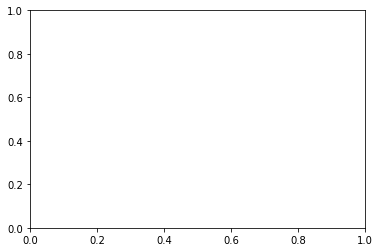

In [101]:
#look at the raw LF samples
# ax = anl.ReconstructedFunction('galaxy_lf', ivar=[6, None], samples='all', color='b', alpha=0.01)

# ax.set_yscale('log')
z = 4.
# 0.35, 0.875, 1.125, 1.75, 2.25, 2.75

gpop = ares.analysis.GalaxyPopulation()

ax = anl.ReconstructedFunction('galaxy_smf', ivar=[z, None], samples='all', color='b', alpha=0.01)

# Plot any data within dz=0.1 of z=6
gpop.PlotSMF(z, ax=ax, round_z=0.2)

ax.set_ylim(1e-9, 1)
ax.legend()
pl.show()

# ax = anl_2.ReconstructedFunction('galaxy_smf', ivar=[z, None], samples='all', color='b', alpha=0.01)
# gpop.PlotSMF(z, ax=ax, round_z=0.2)



In [81]:
params = \
['pq_func_par0[0]',
    'pq_func_par2[0]', 

    #norm
    'pq_func_par0[1]',
    'pq_func_par2[1]', 

    #gamma
    'pq_func_par0[2]',
    'pq_func_par2[2]', 

    #peak mass
    'pq_func_par0[3]',
    'pq_func_par2[3]' 
]

covar = anl.CovarianceMatrix(params)

if len(covar[0]) == 1:
    print("{}: {}".format(params[0], covar[0][0]))
else:
    for i in range(len(covar[0])):
        print("{}: {:e}".format(params[i], covar[0][i]))

pq_func_par0[0]: 7.997620e-01
pq_func_par2[0]: 2.278417e-01
pq_func_par0[1]: 2.726746e-02
pq_func_par2[1]: -6.925874e-01
pq_func_par0[2]: 5.452154e-01
pq_func_par2[2]: -6.228146e-01
pq_func_par0[3]: 1.293545e+01
pq_func_par2[3]: 4.638487e-01


0 of 1500 chain elements ignored because of chain links with inf's/nan's.


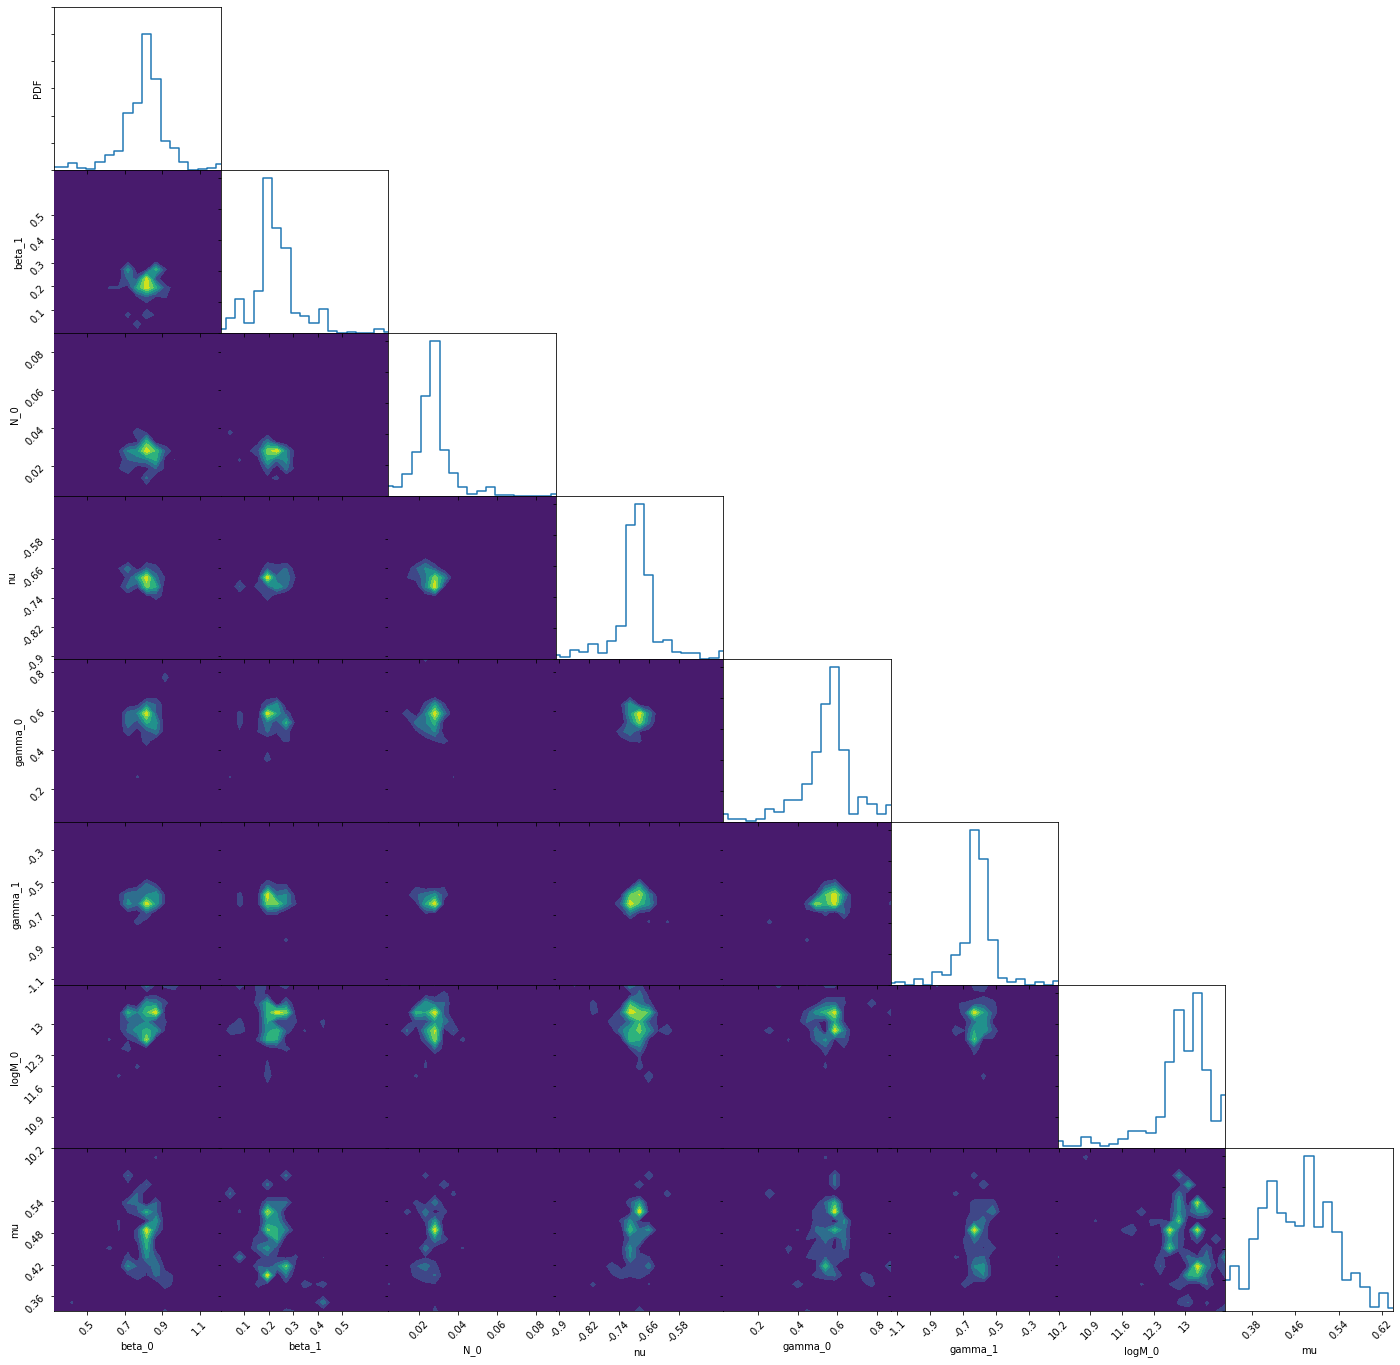

In [82]:

anl.TrianglePlot(pars=params)

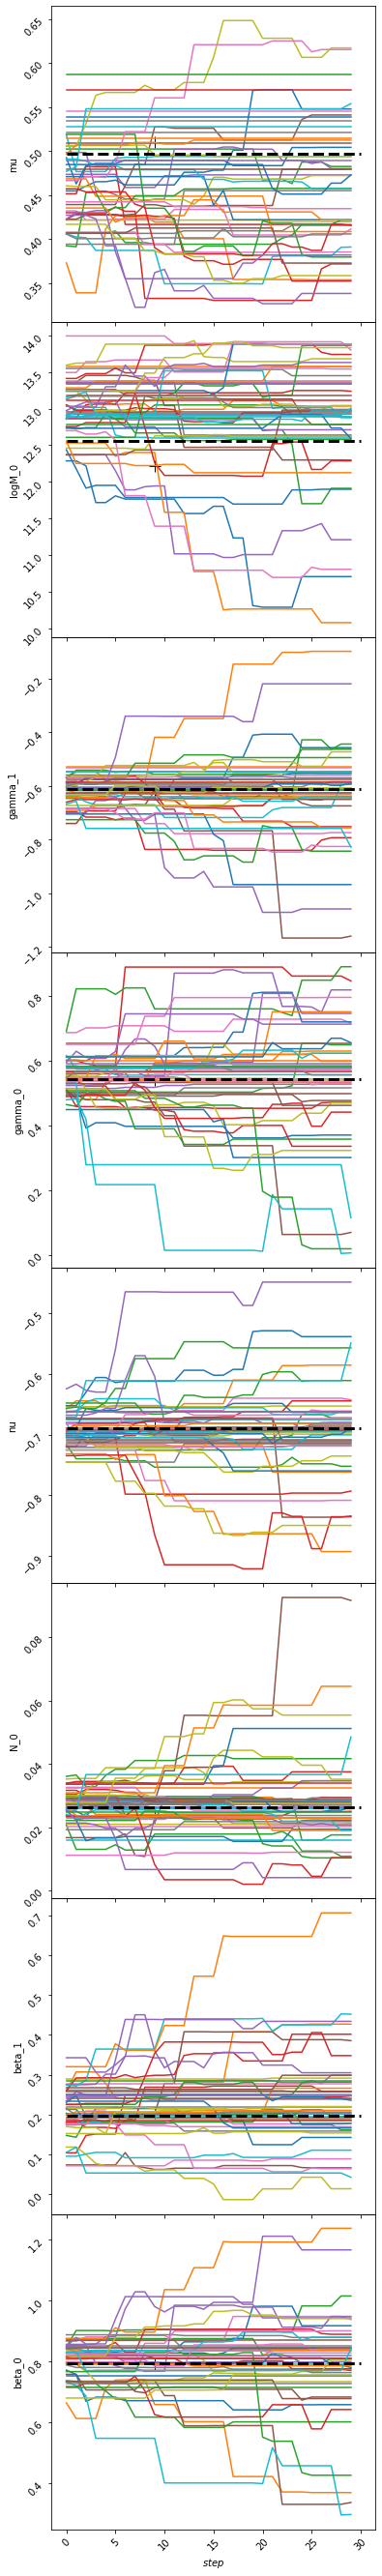

In [83]:
anl.WalkerTrajectoriesMultiPlot(best_fit='mode')
# mode: 2190
# median: -3171602.2183875367

In [ ]:
anl_2.WalkerTrajectoriesMultiPlot(best_fit='mode')


In [87]:
anl.max_likelihood_parameters()

{'pq_func_par0[0]': 0.7960141357750804,
 'pq_func_par2[0]': 0.1983616782821258,
 'pq_func_par0[1]': 0.02629850510530034,
 'pq_func_par2[1]': -0.6896559317117834,
 'pq_func_par0[2]': 0.5412248901608705,
 'pq_func_par2[2]': -0.6133230135773661,
 'pq_func_par0[3]': 12.557751891825447,
 'pq_func_par2[3]': 0.4965702541736125}

In [88]:
anl_2.max_likelihood_parameters()

{'pq_func_par0[0]': 1.0334683986075583,
 'pq_func_par2[0]': -0.3010623457549699,
 'pq_func_par0[1]': 0.020622507972855728,
 'pq_func_par2[1]': -0.5318324877310984,
 'pq_func_par0[2]': 0.8903964995497964,
 'pq_func_par2[2]': -0.8962247367607246,
 'pq_func_par0[3]': 13.984348483127919,
 'pq_func_par2[3]': 1.962884025481726}

In [89]:
covar = anl.CovarianceMatrix(params)

if len(covar[0]) == 1:
    print("{}: {}".format(params[0], covar[0][0]))
else:
    for i in range(len(covar[0])):
        print("{}: {:e}".format(params[i], covar[0][i]))
        
fit_mean = np.array(covar[0])

pq_func_par0[0]: 7.997620e-01
pq_func_par2[0]: 2.278417e-01
pq_func_par0[1]: 2.726746e-02
pq_func_par2[1]: -6.925874e-01
pq_func_par0[2]: 5.452154e-01
pq_func_par2[2]: -6.228146e-01
pq_func_par0[3]: 1.293545e+01
pq_func_par2[3]: 4.638487e-01


In [90]:
pars_ch = {}
for i in range(len(covar[0])):
    pars_ch[params[i]] = covar[0][i]
    
pars_mean = ares.util.ParameterBundle("emma:model1")

pars_mean.update(pars_ch)
# print(pars_best)
pop_mean = ares.populations.GalaxyPopulation(**pars_mean)

In [91]:
fit_best_like = anl.max_likelihood_parameters()

for i in range(len(covar[0])):
    print(anl.get_1d_error(params[i])) #(maximum likelihood value, positive error, negative error).

(0.7960141357750804, array([0.08937417, 0.0795399 ]))
(0.1983616782821258, array([0.09088737, 0.03959073]))
(0.02629850510530034, array([0.00778249, 0.00612421]))
(-0.6896559317117834, array([0.03414622, 0.0357215 ]))
(0.5412248901608705, array([0.0982395 , 0.08908843]))
(-0.6133230135773661, array([0.06461379, 0.09180256]))
(12.557751891825447, array([0.97755096, 0.04963916]))
(0.4965702541736125, array([0.03760868, 0.10223604]))


In [92]:
pars_best = ares.util.ParameterBundle("emma:model1")
print(fit_best_like)

pars_best.update(fit_best_like)
# print(pars_best)
pop_best = ares.populations.GalaxyPopulation(**pars_best)

{'pq_func_par0[0]': 0.7960141357750804, 'pq_func_par2[0]': 0.1983616782821258, 'pq_func_par0[1]': 0.02629850510530034, 'pq_func_par2[1]': -0.6896559317117834, 'pq_func_par0[2]': 0.5412248901608705, 'pq_func_par2[2]': -0.6133230135773661, 'pq_func_par0[3]': 12.557751891825447, 'pq_func_par2[3]': 0.4965702541736125}


In [93]:
fit_best_like_2 = anl_2.max_likelihood_parameters()
pars_best_2 = ares.util.ParameterBundle("emma:model1")
pars_best_2.update(fit_best_like_2)
pop_best_2 = ares.populations.GalaxyPopulation(**pars_best_2)


[-inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf
 -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf
 -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf
 -inf -inf -inf -inf -inf -inf -inf -inf]


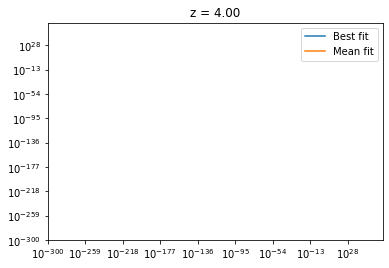

In [104]:
z = 4

Ms_short = np.logspace(8, 12, 50)
# Ms_short = [1e9]

# print(Ms)

ls_best = pop_best.StellarMassFunction(z, Ms_short)
# ls_best_2 = pop_best_2.StellarMassFunction(z, Ms_short)

print(ls_best)

ls_mean = pop_mean.StellarMassFunction(z, Ms_short)

obslf = ares.analysis.GalaxyPopulation()
# obslf.Plot(z=z, round_z=0.2)

pl.loglog(Ms_short, ls_best, label='Best fit')
# pl.loglog(Ms_short, ls_best_2, label='Best fit 2')

pl.loglog(Ms_short, ls_mean, label='Mean fit')
pl.title("z = %.2f" %z)
pl.legend()
# pl.ylim(1e-9, 1e2)
pl.show()